In [30]:
# overhead

import logging
import math 
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt


logger = logging.getLogger(__name__)

In [31]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant  km/s^2
BOOST_ACCEL = 0.18  # thrust constant  km/s^2
ROTATION_ACCEL = 0.2  # rotation constant  km/s^2 (ADDED)
LEFT_SIDE_BOOST_ACCEL = 0.8  # side thrust constant  km/s^2 (ADDED)


# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height

In [32]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust (action[1])
        action_left: left side thrust or no left side thrust (action[0])
        state[0] = y
        state[1] = y_dot
        state[2] = theta (ADDED)
        state[3] = theta_dot (ADDED)
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., -gravity * delta_time], and do x = x + dx. This is allowed... 
        #delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME])
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0, 0]) # (ADDED)

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # The action affects how much the booster acceleration affects the rocket's velocity
        #delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.]) * action[1]
        #delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0.]) * action[1] # (ADDED)
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1., 0., 0.]) * action[1] * t.cos(state[2]) # (ADDED)
        #The cos(theta) portion is because the orientation of the rocket affects how much the BOOST_ACCEL contributes to the linear velocity

        #"""
        # Apply rotation acceleration
        # Note: Here the rotation acceleration is used to change the angular velocity which is the fourth element of the state vector
        # This action makes the rocket rotate counter clockwise 
        delta_state_rotation = t.tensor([0., 0, 0, ROTATION_ACCEL* FRAME_TIME]) # (ADDED)

        # Side Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # The action affects how much the side booster acceleration affects the rocket's angular velocity
        # This action makes the rocket rotate clockwise
        delta_state_angular = LEFT_SIDE_BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0, 0, -1.]) * action[0] # (ADDED)
        #"""

        # Update velocity
        #state = state + delta_state + delta_state_gravity
        state = state + delta_state + delta_state_gravity + delta_state_rotation + delta_state_angular # (ADDED)

        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        #step_mat = t.tensor([[1., FRAME_TIME],
        #                    [0., 1.]])
        #"""
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.], 
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]]) # (ADDED)
        #"""
        #state = t.matmul(step_mat, state)  # Multiplies 2x2 step_mat with 2x1 state matrix
        state = t.matmul(step_mat, state)  # Multiplies 4x4 step_mat with 4x1 state matrix (ADDED)

        return state

In [33]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        #print(action[1])
        return action

In [34]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #state = [1., 0.]  
        state = [1., 0., -1., 0.]  # Initial state values (ADDED)
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        #return state[0]**2 + state[1]**2
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 # (ADDED)

In [35]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2] # (ADDED)
        theta_dot = data[:, 3] # (ADDED)
        
        plt.figure()

        plt.subplot(221)
        #plt.grid(color='k', linestyle='-', linewidth=0.5)
        plt.plot(x, y)
        plt.xlabel('Distance (km)')
        plt.ylabel('Velocity (km/s)')
        plt.title('Velocity vs. Distance')

        plt.subplot(222)
        #plt.grid(color='k', linestyle='-', linewidth=0.5)
        plt.plot(theta, theta_dot)
        plt.xlabel('Angle (rad)')
        plt.ylabel('Angular Velocity (rad/s)')
        plt.title('Angular Velocity vs. Angle')
        plt.tight_layout()

        plt.show()

[1] loss: 16.847


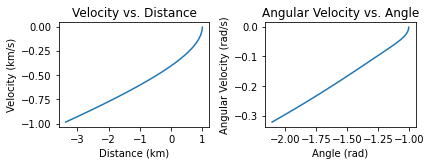

[2] loss: 8.796


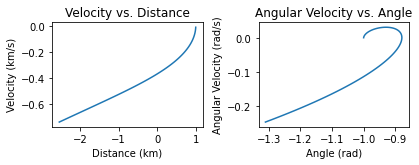

[3] loss: 5.013


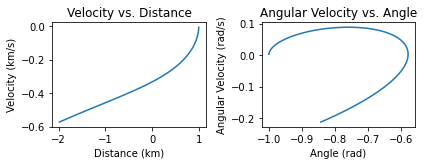

[4] loss: 2.980


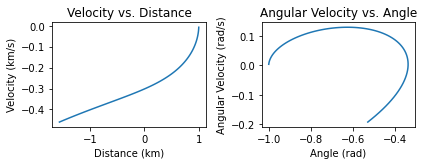

[5] loss: 1.783


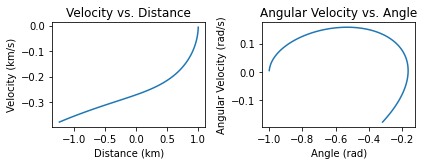

[6] loss: 1.072


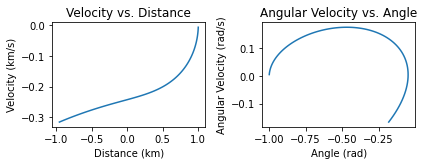

[7] loss: 0.650


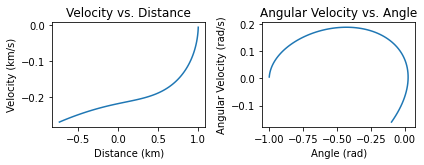

[8] loss: 0.393


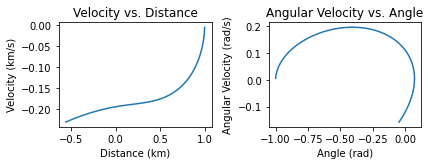

[9] loss: 0.241


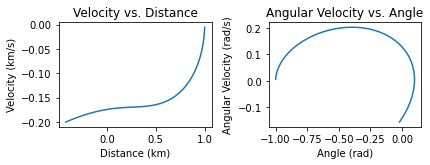

[10] loss: 0.155


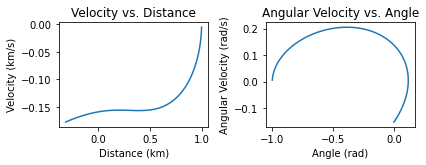

[11] loss: 0.105


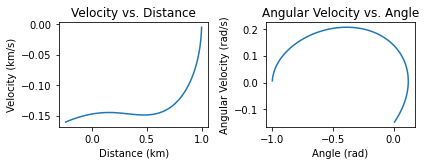

[12] loss: 0.074


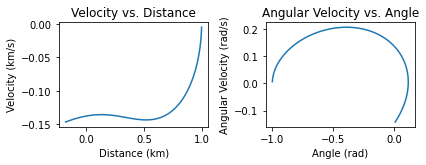

[13] loss: 0.054


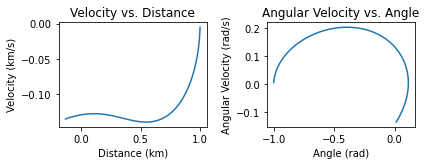

[14] loss: 0.040


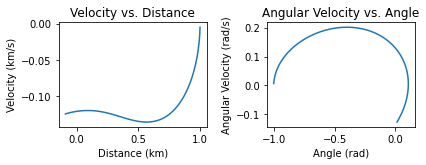

[15] loss: 0.032


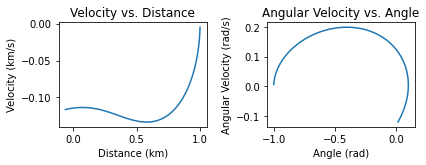

[16] loss: 0.026


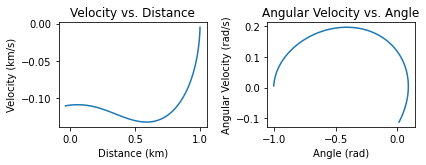

[17] loss: 0.022


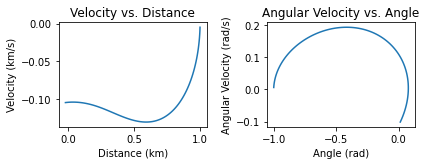

[18] loss: 0.018


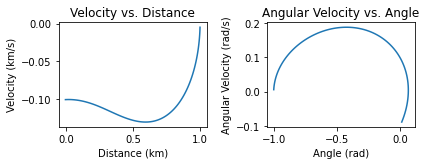

[19] loss: 0.015


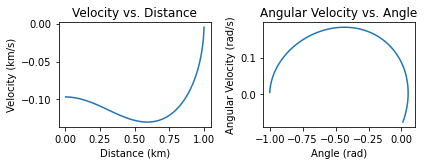

[20] loss: 0.013


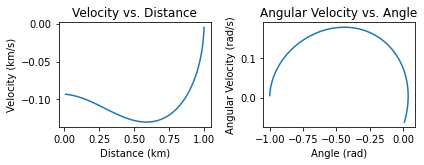

[21] loss: 0.011


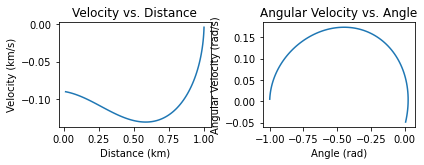

[22] loss: 0.009


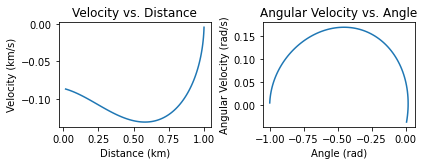

[23] loss: 0.008


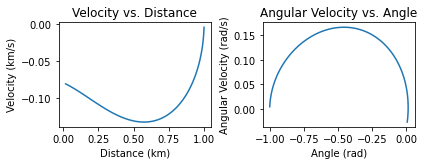

[24] loss: 0.005


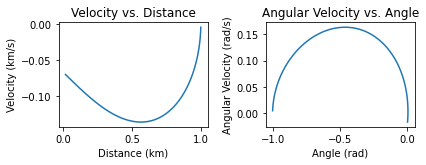

[25] loss: 0.004


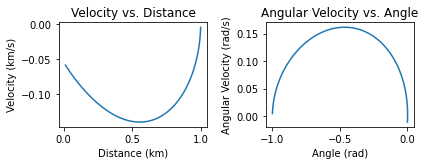

[26] loss: 0.003


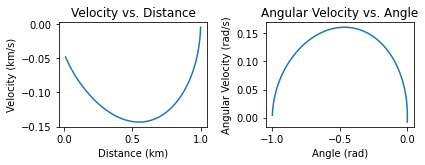

[27] loss: 0.002


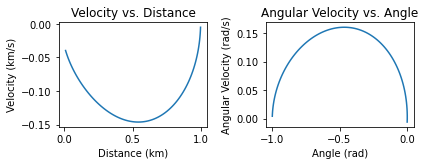

[28] loss: 0.001


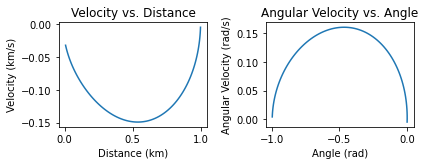

[29] loss: 0.001


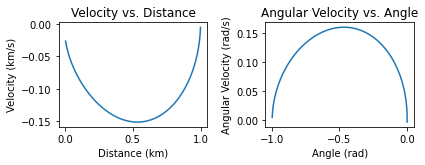

[30] loss: 0.001


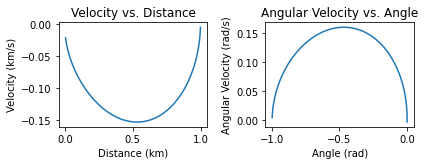

[31] loss: 0.000


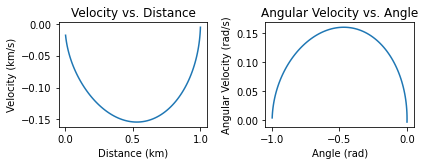

[32] loss: 0.000


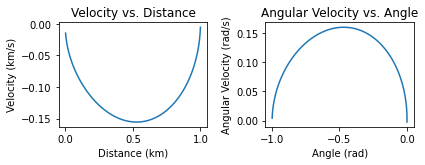

[33] loss: 0.000


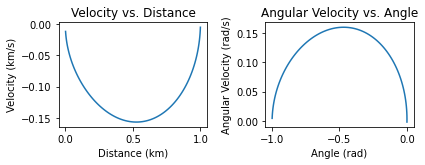

[34] loss: 0.000


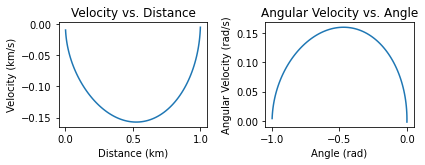

[35] loss: 0.000


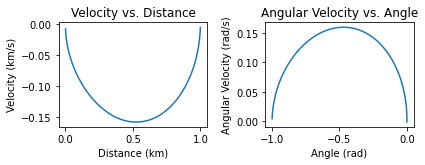

[36] loss: 0.000


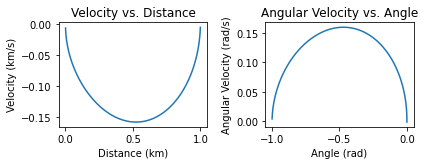

[37] loss: 0.000


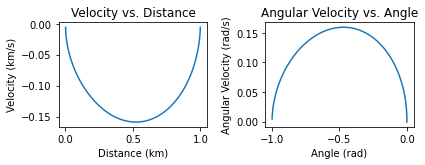

[38] loss: 0.000


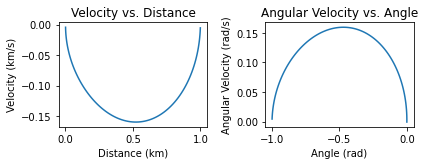

[39] loss: 0.000


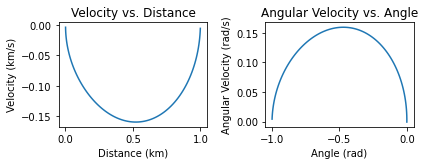

[40] loss: 0.000


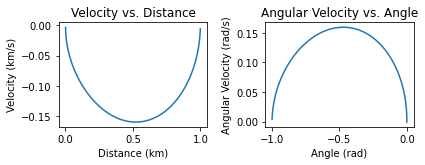

In [36]:
# Now it's time to run the code!

T = 100  # number of time steps
#dim_input = 2  # state space dimensions
dim_input = 4  # state space dimensions (Distance, Velocity, Angle, Angular Velocity) (ADDED)
dim_hidden = 12  # latent dimensions
#dim_output = 1  # action space dimensions
dim_output = 2  # action space dimensions (Acceleration, Angular Acceleration) (ADDED)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem